***
# Part 0: Preparing the Network
***

This part includes everything needed to make the rock bands network

In [ ]:
# Fetching the data and saving to computer

UA = "Mozilla/5.0 (student project)"
BASEURL = "https://en.wikipedia.org/w/api.php?"
OUTDIR = "Assignment 1 data"
os.makedirs(OUTDIR, exist_ok=True)

# Fetch list of performer names from Wikipedia
params = {
    "action": "query",
    "titles": "List_of_mainstream_rock_performers",
    "prop": "revisions",
    "rvprop": "content",
    "format": "json"

req = urllib.request.Request(BASEURL + urllib.parse.urlencode(params), headers={"User-Agent": UA})
with urllib.request.urlopen(req) as response:
    data = json.loads(response.read().decode("utf-8"))

# Extract wikitext and performer names
wikitext = list(data["query"]["pages"].values())[0]["revisions"][0]["*"]
matches = re.findall(r"^\* \[\[(.*?)(?:\|(.*?))?\]\]", wikitext, flags=re.M)

names = [full for (full, display) in matches]
labels = {full: (display if display else full) for (full, display) in matches}
print(f"{len(names)} performer names found")


saved_files = []
for i, name in enumerate(names, 1):
    title_raw = name.replace(" ", "_")
    title_enc = urllib.parse.quote(title_raw)

    params = {
        "action": "query",
        "titles": title_raw,
        "prop": "revisions",
        "rvprop": "content",
        "format": "json"
    }

    # Fetch data
    try:
        req = urllib.request.Request(BASEURL + urllib.parse.urlencode(params), headers={"User-Agent": UA})
        with urllib.request.urlopen(req) as response:
            data = json.loads(response.read().decode("utf-8"))
        page = next(iter(data["query"]["pages"].values()))
        rev = page["revisions"][0]
        wikitext = rev["*"] if "*" in rev else rev["slots"]["main"]["*"]
    except Exception as e:
        print(f"⚠️ Skipped {name}: {e}")
        continue

    # Save to computer
    safe_filename = re.sub(r'[\\/*?:"<>|]', "_", title_raw)
    filepath = os.path.join(OUTDIR, safe_filename + ".txt")
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(wikitext)

    saved_files.append(filepath)
    if i % 25 == 0:
        print(f"Saved {i}/{len(names)} pages")
    time.sleep(0.05)

print(f"\n✅ Total files saved: {len(saved_files)} → folder '{OUTDIR}'")

In [ ]:
# Build the directed graph
OUTDIR = "Assignment 1 data"

files = [f for f in os.listdir(OUTDIR) if f.endswith(".txt")]
performers = [f[:-4] for f in files]
performer_set = set(performers)

G = nx.DiGraph()
G.add_nodes_from(performers)
print(f"Initialized graph with {G.number_of_nodes()} nodes")

# Compile regex once
link_pattern = re.compile(r'\[\[([^\]|#]+)(?:\|[^\]]+)?\]\]')

edge_count = 0
for file in files:
    source = file[:-4]
    path = os.path.join(OUTDIR, file)

    with open(path, "r", encoding="utf-8") as f:
        wikitext = f.read()

    G.nodes[source]["word_count"] = len(wikitext)

    for t in link_pattern.findall(wikitext):
        if ":" in t:
            continue
        t = re.sub(r'[\\/*?:"<>|]', "_", t.strip().replace(" ", "_"))
        if t in performer_set and t != source:
            G.add_edge(source, t)
            edge_count += 1

print(f"Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges added ({edge_count} total)")

In [ ]:
# Adding text as node attributes

TEXT_DIR = "Assignment 1 data"

for node in G.nodes():
    filename = re.sub(r'[\\/*?:"<>|]', "_", node.replace(" ", "_")) + ".txt"
    path = os.path.join(TEXT_DIR, filename)
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            G.nodes[node]["text"] = f.read()

In [ ]:
# Adding genre as node attributes

UA = "Mozilla/5.0 (student project)"
WIKI_API   = "https://en.wikipedia.org/w/api.php"
SPARQL_URL = "https://query.wikidata.org/sparql"

S = requests.Session()
S.headers.update({"User-Agent": UA})

def get_genres(title):
    try:
        # resolve Wikipedia title -> Wikidata QID
        r = S.get(WIKI_API, params={
            "action": "query", "titles": title, "prop": "pageprops",
            "redirects": 1, "format": "json"
        }, timeout=20)
        page = next(iter(r.json()["query"]["pages"].values()))
        qid = page.get("pageprops", {}).get("wikibase_item")
        if not qid:
            return []
        # fetch genres (P136) from Wikidata
        query = f"""
        SELECT ?genreLabel WHERE {{
          wd:{qid} wdt:P136 ?genre .
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
        }}
        """
        r = S.get(SPARQL_URL,
                  params={"query": query, "format": "json"},
                  headers={"Accept": "application/sparql-results+json"},
                  timeout=30)
        rows = r.json()["results"]["bindings"]
        return sorted({row["genreLabel"]["value"].strip().lower() for row in rows})
    except Exception:
        return []

# attach genres; count missing
missing = 0
for node in G:
    gs = get_genres(node.replace("_", " "))
    G.nodes[node]["genres"] = gs
    if not gs:
        missing += 1

print(f"Genres attached. Missing for {missing}/{G.number_of_nodes()} nodes.")


In [ ]:
# Saving the network file to computer in JSON format

# Convert the graph to a JSON-serializable format
data = json_graph.node_link_data(G)

with open("rock_artist_network.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=2)
print("Saved 'rock_artist_network.json'")

***
# Part 1: Analyze the network 
***

The questions in this part are based on Lecture 5.

**Question from Assignment**

Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.

- It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
- I would like you to include concepts like centrality and assortativity in your analysis.
- Use a network backbone in your analysis.
- In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).

*Note: As I write above, an important part of the exercise consists is selecting the right elements of the lecture to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.*


## Introduction to the Network and Macro-Structure of the Network

This section explains that the network represents artists/bands connected through Wikipedia links, which likely reflect collaboration or shared membership. It checks how many artists are connected overall, identifies a giant component of ~397 nodes (mainly rock-related acts), and notes that a few artists have many links while most have few. It gives a qualitative sense of what the edges represent before going into metrics.

**Network intorduction**

Networks help represent relationships between entities. In this case, nodes are artists and bands, and edges are Wikipedia links between their pages. These links may reflect influence, shared history, genre associations, or general relevance, rather than direct collaboration. The goal is to understand the structure of this network and identify which artists appear most central or important in how music information is connected online.

First, the basic structure of the network is examined. To get an overview of the network, key properties such as the number of nodes and edges, the size of the largest connected component, and the degree distribution are considered. This shows how large the network is, how many artists are indirectly connected, and whether a few artists receive most of the links.

In [2]:
# Import necessary libraries
import os, re, time, urllib.parse, urllib.request, gzip, json
from collections import defaultdict, Counter

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity

from adjustText import adjust_text
from backboning import disparity_filter, thresholding, high_salience_skeleton


ModuleNotFoundError: No module named 'adjustText'

The Largest component has 397  Nodes and 4517 Edges


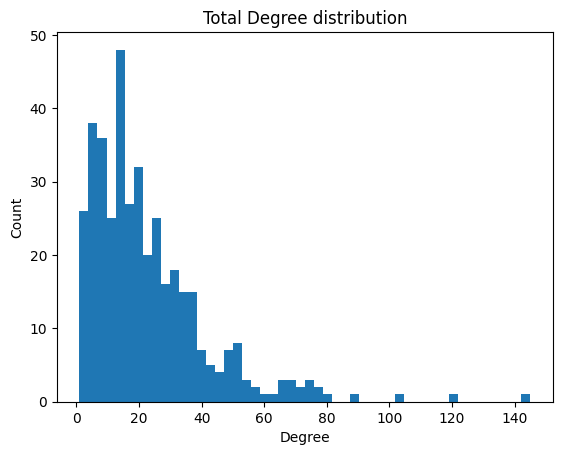

In [ ]:
# Get file from folder named rock_bands.gexf

# Load the graph
G = nx.read_gexf('rock_bands.gexf')
# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# use weakly connected components to extract the largest component
giant_nodes = max(nx.weakly_connected_components(G), key=len)

# Keep only the largest component and make it undirected, copy() preserves node/edge attributes 
G = G.subgraph(giant_nodes).copy()
G_und = G.to_undirected()

print("The Largest component has",G_und.number_of_nodes()," Nodes and", G_und.number_of_edges(), "Edges")

# Degree distribution
deg = [d for _, d in G_und.degree()]

plt.figure()
plt.hist(deg, bins=50)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Total Degree distribution")
plt.show()


As seen above, the largest componet has 397 nodes (rock artist/bands) and 5549 Edges. The degree distribution shows that most nodes have relatively few links, while a smaller number of artists have a high number of connections. This long-tailed pattern is typical in information networks and suggests that a few artists are referenced frequently, while most are referenced less often.

Before turning to quantitative measures, a brief qualitative inspection is useful to understand why edges exist in this network. By examining artists with many links and those with few, the aim is to understand what types of relationships the Wikipedia links are likely to represent

## Qualitative and Quantitative Inspection of Edges
This section looks closely at a sample of edges to confirm what kinds of relationships the Wikipedia links capture (shared band members, collaboration, etc.). It then quantifies edge weights and connectivity patterns, showing that the network has uneven connection strengths and that many edges represent low-frequency links while a smaller portion reflect strong shared ties.


Before applying network metrics, a short qualitative inspection helps understand what edges represent in this dataset. By looking at artists with many links and those with few, it becomes possible to see what kinds of relationships Wikipedia hyperlinks capture. 

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


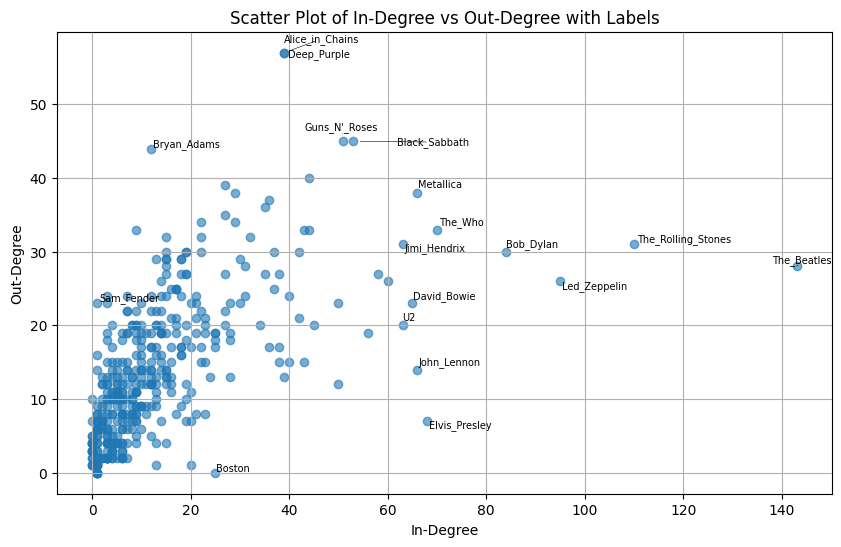

In [ ]:
in_degrees_list = [dict(G.in_degree())[n] for n in G.nodes()]
out_degrees_list = [dict(G.out_degree())[n] for n in G.nodes()] 

# threshold and labels for nodes exceeding thresholds
threshold_in = 60
threshold_out = 40
labels = {}
for n in G.nodes():
    in_deg = dict(G.in_degree())[n]
    out_deg = dict(G.out_degree())[n]
    if in_deg > threshold_in or out_deg > threshold_out or (in_deg > 20 and out_deg < 3) or (out_deg > 20 and  in_deg< 3):
        labels[n] = n  

# Scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(in_degrees_list, out_degrees_list, alpha=0.6)

texts = []
for n, label in labels.items():
    x = dict(G.in_degree())[n]
    y = dict(G.out_degree())[n]
    # small initial offset to help start movement
    texts.append(plt.text(x, y, label, fontsize=7))

# Adjust labels with more force + movement allowed both axes
adjust_text(
    texts,
    expand_text=(1.2, 1.4),
    expand_points=(1.2, 1.4),
    force_points=0.3,
    force_text=0.3,
    only_move={'points': 'xy', 'text': 'xy'},
    arrowprops=dict(arrowstyle='-', lw=0.4, shrinkA=5, shrinkB=5)
)

# labels and style
ax.set_xlabel("In-Degree")
ax.set_ylabel("Out-Degree")
ax.set_title("Scatter Plot of In-Degree vs Out-Degree with Labels")
ax.grid(True)

plt.show()





From the degree patterns, most artists have only a limited number of incoming links, while a few receive a very large number. This shows that recognition in the network is highly concentrated around a small group of iconic artists, while most are only referenced a few times. Outgoing links, however, are more evenly spread, with many artists linking to a similar number of others. This means that references to other artists are relatively broad, while attention and recognition are focused on a select few.

**Walk through of a few selected artist for qualitive analysis of their point in the scatter plot**

Looking at the scatter plot above, the Beatles stands out with the highest number of incoming links, reflecting their major cultural influence and the fact that many artists reference them. In contrast, Deep Purple and Alice in Chains have some of the highest outgoing link counts, likely due to genre ties, shared members, and detailed contextual information on their pages. Most artists cluster at lower in-degree values with moderate out-degree values, meaning they reference others but are not widely referenced themselves. For example, Sam Fender links to many influences but is still relatively new in terms of recognition, while Boston shows the opposite pattern, often referenced by others but linking out less, consistent with being a well-established classic act.

Having interpreted what high and low degree values suggest about how artists are linked on Wikipedia, the analysis now shifts to a more systematic examination of importance in the network.

## Centrality and Network Structure
This section computes centrality measures to identify important artists in the network. It compares degree, betweenness, and other centrality scores, showing that certain artists act as major hubs or bridges in the collaboration structure. It interprets which artists are structurally significant and how their influence differs depending on centrality type


Centrality measures allow a structured way to identify artists who hold prominent positions in the network. These metrics highlight which artists attract attention, sit at strategic bridging points, or play influential roles in how information is connected across the music domain.

In [ ]:
# Total degree centrality (normalized)
# Centrality measures
deg_cent = nx.degree_centrality(G_und)
bet_cent = nx.betweenness_centrality(G_und)
eig_cent = nx.eigenvector_centrality(G_und, max_iter=500)

# DataFrame
cent_df = pd.DataFrame({
    "artist": list(G_und.nodes()),
    "degree": [deg_cent[n] for n in G_und.nodes()],
    "betweenness": [bet_cent[n] for n in G_und.nodes()],
    "eigenvector": [eig_cent[n] for n in G_und.nodes()]
})

# Sort and take top 5
top_deg  = cent_df.sort_values("degree", ascending=False).head(5)
top_bet  = cent_df.sort_values("betweenness", ascending=False).head(5)
top_eig  = cent_df.sort_values("eigenvector", ascending=False).head(5)



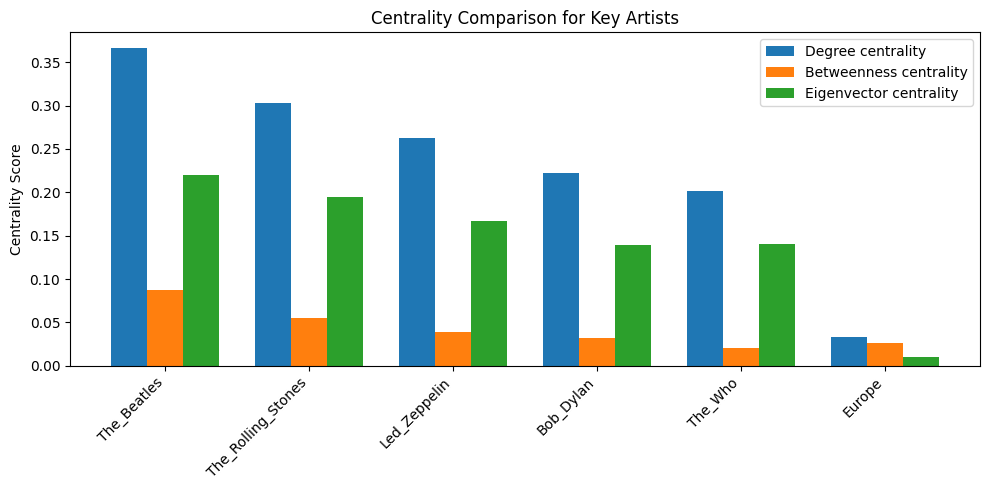

In [4]:
# Combine unique artists from all top lists
selected = pd.concat([top_deg, top_bet, top_eig]).drop_duplicates("artist")

# Sort for nicer plotting
selected = selected.sort_values("degree", ascending=False)

# Plot grouped bars
x = np.arange(len(selected))  # label positions
width = 0.25

plt.figure(figsize=(10,5))

plt.bar(x - width, selected["degree"], width, label="Degree centrality")
plt.bar(x,         selected["betweenness"], width, label="Betweenness centrality")
plt.bar(x + width, selected["eigenvector"], width, label="Eigenvector centrality")

plt.xticks(x, selected["artist"], rotation=45, ha="right")
plt.ylabel("Centrality Score")
plt.title("Centrality Comparison for Key Artists")
plt.legend()
plt.tight_layout()
plt.show()


The plot above compares degree, betweenness, and eigenvector centrality for key artists in the network, having expressed the top 5 for each centrality, showing overlap between the centrality measures. Across all measures, The Beatles and The Rolling Stones stand out as the most central nodes. They have the highest degree centrality, meaning they are directly connected to the largest number of other artists, and their high eigenvector scores show they are connected to other influential nodes. Their relatively elevated betweenness values indicate that they also act as bridges between different parts of the network, facilitating information flow between communities. By contrast, Europe has much lower scores across all metrics, indicating a more peripheral position in the collaboration network.

While centrality highlights which individual artists hold the most influence and act as key hubs or bridges, it does not tell us how these influential artists tend to connect across the network as a whole. To better understand the overall collaboration structure, we next examine degree assortativity

In [5]:
# figure out if the undirected version of the graph assortatice on degree
assortativity = nx.degree_assortativity_coefficient(G_und)
print(f"Degree Assortativity Coefficient of the undirected graph: {assortativity}")

Degree Assortativity Coefficient of the undirected graph: -0.024639989796651548


The assortativity coefficient is close to zero (−0.025), indicating no there is no significant correlation between the properties of connected artist. Since the network does not show strong clustering among similarly connected artists, and having almost 400 nodes and more than 4000 edges, the visualization of the network would be a hairnet strcutre, so extracting a backbone can help highlight the most meaningful reference patterns and reveal core structural relationships.


## Backbones and Network Visualization
This section applies a backbone extraction method to filter out weak ties and highlight the most meaningful connections. It reports how many nodes and edges remain, then visualizes the backbone to reveal clearer clusters and key bridging artists. A visualization is used to show communities and major connectors that are hidden in the full dense network

As introduced in Lecture 5, the disparity filter is applied to extract the backbone of the network. The implementation follows the recommended method, but minor adjustments were made to ensure compatibility with newer library functions, as the original code dated back to 2017 (or earlier). The updated script used for this analysis is attached.

The disparity filter requires weighted edges. To meet this requirement, edge weights were defined as 1 / edge betweenness centrality. The network shows a degree assortativity close to zero, indicating that highly connected artists do not consistently connect to other highly connected artists. In this structure, using raw betweenness would place most of the weight on a small number of bridge edges and under-represent connections within local collaboration communities. By using 1 / betweenness, more emphasis is placed on locally embedded ties, allowing the backbone to better reflect the community-driven nature of artist collaborations in the dataset, as identified earlier in the qualitative analysis.

The below analysis firstly caluclates the scores given the disparity_filter from backboning. These scores needes to be fitler according to a thershold, $\alpha$. As the thershold is central to how spare the network becomes, an analysis with different alpha values was constructed.

In [ ]:
# create weights to network G based on edge betweenness centrality, renormalized so lowest value equal 1 and highest value equal 100
edge_betweenness = nx.edge_betweenness_centrality(G_und)
min_betweenness = min(edge_betweenness.values())
max_betweenness = max(edge_betweenness.values())
edge_weights = {edge: 1 + 99 * (betweenness - min_betweenness) / (max_betweenness - min_betweenness) for edge, betweenness in edge_betweenness.items()}

#copy graph, and cal it G2
G_dis = G_und.copy()

# set all weights to 1/edge_weights[edge]
inverse_edge_weights = {edge: 1 / weight for edge, weight in edge_weights.items()}
nx.set_edge_attributes(G_dis, inverse_edge_weights, 'weight')

# Convert edge list to DataFrame with correct columns
table_dis = pd.DataFrame(
    [(u, v, d["weight"]) for u, v, d in G_dis.edges(data=True)],
    columns=["src", "trg", "nij"]
)
# Apply disparity filter
result_dis = disparity_filter(table_dis, undirected=True)  # or True if your graph is undirected

Calculating DF score...


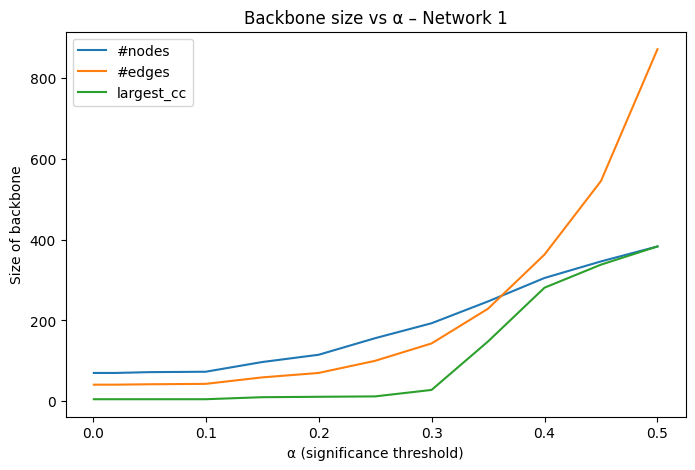

In [7]:
alphas = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1,0.15, 0.2, 0.25,0.3,0.35,0.4,0.45,0.5]
nodes_kept = []
edges_kept = []
largest_cc = []

for α in alphas:
    df_b = result_dis[result_dis["score"] < α]
    import networkx as nx
    B = nx.Graph()
    for _, row in df_b.iterrows():
        B.add_edge(row["src"], row["trg"], weight=row["nij"], score=row["score"])
    # remove isolates
    B.remove_nodes_from([n for n,d in B.degree() if d==0])
    nodes_kept.append(B.number_of_nodes())
    edges_kept.append(B.number_of_edges())
    # largest connected component size
    if B.number_of_nodes() > 0:
        largest_cc.append(len(max(nx.connected_components(B), key=len)))
    else:
        largest_cc.append(0)

plt.figure(figsize=(8,5))
plt.plot(alphas, nodes_kept, label='#nodes')
plt.plot(alphas, edges_kept, label='#edges')
plt.plot(alphas, largest_cc, label='largest_cc')

plt.xlabel('α (significance threshold)')
plt.ylabel('Size of backbone')
plt.title('Backbone size vs α – Network 1')
plt.legend()
plt.show()

Based on the plot, a good choice is $\alpha ≈ 0.3$.

At this level, the backbone is still connected and captures the core structure without becoming too large or too close to the full network. Lower values keep too few edges, and higher values add many edges and reduce the filtering effect.


In [40]:
alpha = 0.38
g1_backbone = result_dis[result_dis["score"] < alpha]

graph_dis = nx.Graph()
for _, row in g1_backbone.iterrows():
    graph_dis.add_edge(row["src"], row["trg"], weight=row["nij"], score=row["score"])

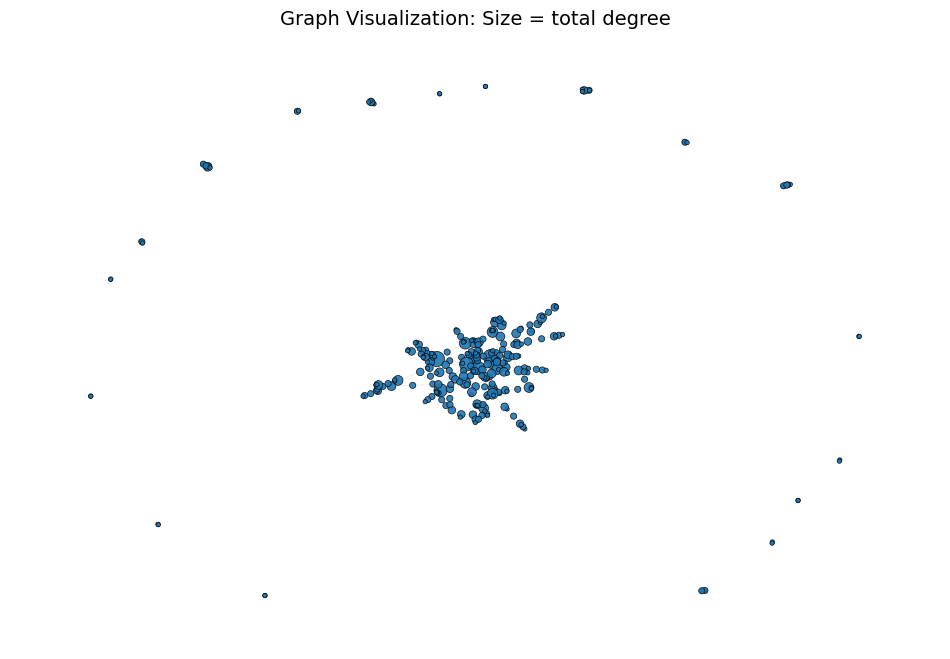

In [41]:
#Remove disconnected nodes
graph_dis.remove_nodes_from([n for n,d in graph_dis.degree() if d==0])

#size nodes according to degree
degrees_B1 = dict(graph_dis.degree())
node_sizes_B1 = np.array([degrees_B1[n]*10 for n in graph_dis.nodes()])

pos = nx.forceatlas2_layout(graph_dis, max_iter=1000)  # alternative to forceatlas2

plt.figure(figsize=(12, 8))

# Draw edges
nx.draw_networkx_edges(graph_dis, pos, alpha=0.2, width=0.5, edge_color="gray")

nodes = nx.draw_networkx_nodes(
    graph_dis,
    pos,
    node_size=node_sizes_B1,
    cmap=plt.cm.viridis,
    alpha=0.9,
    linewidths=0.5,
    edgecolors="black"
)

plt.axis("off")
plt.title("Graph Visualization: Size = total degree", fontsize=14)
plt.show()

The graph shows one main cluster of artists. Most artists are connected to each other, and a few have more links than others, shown by the larger node sizes. This means the network has a clear center of highly connected artists, with others linked around them.

To explore one of the small componets, to understand its grouping, the bands/artist from a random of the componets is chosen and looked at:

In [ ]:
# get connected components
components = list(nx.connected_components(graph_dis)) 

# Pick the cluster 6 (random, wanted to find a small one)
cluster_nodes = components[6]

# Print the artist names in that cluster
print(cluster_nodes)

{"Manfred_Mann's_Earth_Band", 'Manfred_Mann_(musician)', 'Bruce_Springsteen'}


This cluster links Bruce Springsteen with Manfred Mann and Manfred Mann’s Earth Band. The connection is clear: Manfred Mann’s Earth Band famously covered several Bruce Springsteen songs, including “Blinded by the Light” and “Spirit in the Night,” helping bring Springsteen’s early work to a wider audience. This cluster therefore represents a direct influence and song-cover relationship, rather than broader genre similarity

In [43]:
# figure out if the undirected version of the graph assortatice on degree
assortativity = nx.degree_assortativity_coefficient(graph_dis)
print(f"Degree Assortativity Coefficient of the undirected graph: {assortativity}")

Degree Assortativity Coefficient of the undirected graph: -0.1802154506009674


***
# Part 2: Genres and communities and plotting 
***
The questions below are based on Lecture 7, part 2.

* Write about genres and modularity.
* Detect the communities, discuss the value of modularity in comparison to the genres.
* Calculate the matrix $D$ and discuss your findings.
* Plot the communities and comment on your results.


**Introduction**

This part will now dive further into the analysis of the rock band network, by detecting communities and structure within. The basic network will now include genre as an attribute to each node. Comparing if music genre is well suited for partitioning the network. 

Modularity is used for determining communties, and is a highly relevant measure used to determine the clustering within a network. If the network has more dense communities with high internal connections it indicates distinct groups mostly seperated from eachother. A high modularity of a network means these distinct groups exist, while a lower modularity is the opposite. 

For our project the focus is genre for a rockband network. A high modularity in this context reveals rockbands with the same genre tends to be more connected, while the opposite would be that genres overlap and different genre connections are common. 



In [3]:
base_url = "https://raw.githubusercontent.com/AlexJHage/Rock-band-network/main/rock_artist_network.json"

# Read JSON directly from GitHub
response = urllib.request.urlopen(base_url).read()
data = json.loads(response.decode("utf-8"))

# Convert to NetworkX graph
G = json_graph.node_link_graph(data)

c:\Users\alexj\anaconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:290: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


**Caluclating modularity**  
To reveal hidden structures and communties within the network, two methods was used.

 - First method: Partitioning the network by dominant genre.
 - Second method: Using the Louvain algorithm.

Because many nodes had multiple genres listed in an arbitrary order, the first genre was not always the most representative. Therefore, a refined approach was applied using the dominant genre. For each node in the network, its neighbors and their genres were identified. The most common genre among the neighbors was determined. If the node shared this genre, it was assigned as its dominant genre. Otherwise, the nodes first listed genre was used.

In [ ]:
# Make undirected graph
UG = nx.Graph(G)

# Choosing the dominant genre instead of first
dominant_genre = {}
for n in UG.nodes():
    own_genres = G.nodes[n].get("genres", [])
    if not own_genres:
        continue

    # Gather all genres among neighbors
    neighbor_genres = []
    for v in UG.neighbors(n):
        neighbor_genres.extend(G.nodes[v].get("genres", []))

    # Pick the most common neighbor genre if possible
    if neighbor_genres:
        most_common = Counter(neighbor_genres).most_common(1)[0][0]
        if most_common in own_genres:
            dominant_genre[n] = most_common
        else:
            dominant_genre[n] = own_genres[0]
    else:
        dominant_genre[n] = own_genres[0]


# Keep only nodes that have at least one genre
nodes = [n for n in UG if G.nodes[n].get("genres")]
UG = UG.subgraph(nodes)

# Use dominant genre for modularity
partition = dominant_genre

# Calculate modularity
L = UG.number_of_edges()
kc, Lc = defaultdict(int), defaultdict(int)

for v, d in UG.degree():
    kc[partition[v]] += d

for u, v in UG.edges():
    if partition[u] == partition[v]:
        Lc[partition[u]] += 1

M = sum((Lc[c] / L) - (kc[c] / (2 * L))**2 for c in set(partition.values()))
print(f"Modularity (dominant-genre partition): {M:.4f}")

Modularity (dominant-genre partition): 0.1711


In [6]:
communities = louvain_communities(UG)

# Compute modularity of Louvain partition
M_louvain = modularity(UG, communities)

print(f"Louvain modularity: {M_louvain:.4f}")
print(f"Number of detected communities: {len(communities)}")

Louvain modularity: 0.3370
Number of detected communities: 8



Using the Louvain algorithm, the network got a modularity of 0.34, compared to 0.17 for the genre-based partition. This suggests that the genre-based method does detect some community structure, but the boundaries between groups are relatively weak. This result is makes sense, as rock bands are typically categorized by genre and often reference or link to other bands within the same category. However, since all nodes represent rock bands, many nodes have overlapping genres, making a clear structural separation difficult. FUrthermore, many of these are subgenres, and it can be diffucult to see the direct difference between many of the listed genres. 

The Louvain method, in contrast, detects communities using the networks structure. A modularity of 0.34 is moderate high, and indicates some clustering, but not very strong separation. Nonetheless, it performs significantly better than the genre-based partition, showing that network topology reveals stronger communities than genre labels alone.

**Confusion Matrix**  
Next part is comparing the genre partition and the Louvian algorithm results using an confusion matrix. For this part the dominant genre is still used 

In [12]:
# --- Build partition: dominant genre (fallback to first) ---
# assumes you already computed `dominant_genre` dict: {node: genre}
common_nodes = [n for n in UG if G.nodes[n].get("genres")]

partition = {}
for n in common_nodes:
    if n in dominant_genre:
        partition[n] = dominant_genre[n]
    else:
        # fallback to first-listed genre
        partition[n] = G.nodes[n]["genres"][0]

# --- Louvain community id per node ---
comm_dict = {node: i for i, comm in enumerate(communities) for node in comm}

# --- Confusion matrix (genre × community) ---
df = pd.DataFrame({
    "genre":     [partition[n] for n in common_nodes],
    "community": [comm_dict.get(n) for n in common_nodes]
}).dropna()

D = pd.crosstab(df["genre"], df["community"])

# --- Show top 10 genres by frequency ---
top_genres = D.sum(axis=1).sort_values(ascending=False).head(100).index
D_top = D.loc[top_genres]

print("Shape of D_top matrix:", D_top.shape)
display(D_top)


Shape of D_top matrix: (64, 8)


community,0,1,2,3,4,5,6,7
genre,,,,,,,,
alternative rock,19,0,4,6,1,0,88,0
rock music,0,1,8,81,0,0,5,0
hard rock,15,0,56,5,0,0,4,0
alternative metal,9,0,9,0,0,0,5,0
heavy metal,1,0,12,0,0,0,0,0
...,...,...,...,...,...,...,...,...
contemporary classical music,0,0,0,1,0,0,0,0
emo,0,0,0,0,0,0,1,0
electronic rock,0,0,0,0,0,0,1,0


To give a quick overview the matrix only displays the cluster created by the top 10 most commmon genres but can easily be changed. The algorithm then gave 8 clusters as the optimal solution, and it seems like only 4 of them have more than just a few nodes. The gernes displayed as rows are sorted in a descending order of total count, where "alternative rock" the one with most nodes. This gerne is included in 5 of the 8 structural communties found, but mostly in number 6. Almost the same is seen with "rock music" which mostly lies in community 3, but are still appearing in other clusters. This supports the idea that genres still has a significant effect on the structural communities in the network.

The less popular genres does not follow this conclusion, and must not be significant enough to have an impact on the structural part of the network. Also by choosing the strategy of dominant genres the results might be a little biased, because if many nodes has one genre it will most of the time be chosen as the dominant one for them all. 

**Plotting the communtities**

C:\Users\alexj\AppData\Local\Temp\ipykernel_32448\185527933.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", TOP_K)


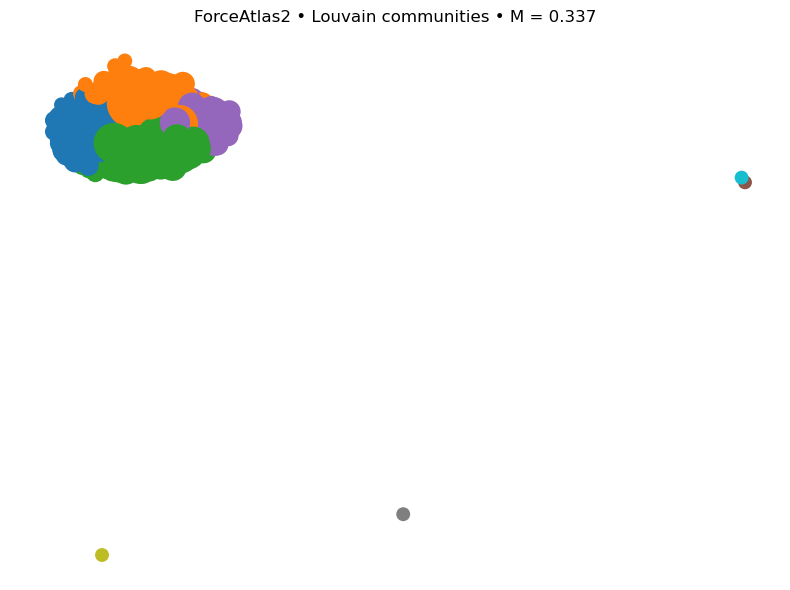

In [14]:
# map node -> community id, largest communities first
comms = sorted(communities, key=len, reverse=True)
cid = {n: i for i, C in enumerate(comms) for n in C}
TOP_K = 8

# degree-based sizes (normalized)
deg = np.array([UG.degree(n) for n in UG.nodes()], float)
deg = (deg - deg.min()) / (deg.max() - deg.min() + 1e-9)
sizes = 100 + deg * (2000 - 100)

# ForceAtlas2 layout (NetworkX 3.5)
pos = nx.forceatlas2_layout(UG, max_iter=500)

# colors: top-K use tab10, others light gray
import matplotlib.cm as cm
cmap = cm.get_cmap("tab10", TOP_K)
colors = [cmap(cid[n]) if cid[n] < TOP_K else (0.85, 0.85, 0.85, 0.7) for n in UG.nodes()]

# plot
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw_networkx_edges(UG, pos, alpha=0.25, width=0.4, ax=ax)
nx.draw_networkx_nodes(UG, pos, node_size=sizes, node_color=colors, linewidths=0.0, ax=ax)
ax.set_title(f"ForceAtlas2 • Louvain communities • M = {M_louvain:.3f}")
ax.axis("off")
plt.tight_layout()
plt.show()


As seen before, there is 4 communities with most of the nodes. Whereas, 4 other communities has only a couple, and represent bands that are weakly connected or have links only to a small number of others. The large connected core represents mainstream rockartists probably with many overapping genres. Together with the modularity of 0.34, it indicates interlinked communities, but still seperated. 
